In [1]:
import pystac
items = pystac.ItemCollection.from_file("search.json")

In [3]:
visual_href = items[-1].assets["visual"].get_absolute_href()

In [5]:
scl_href = items[-1].assets["SCL"].get_absolute_href()

In [6]:
import rioxarray

In [7]:
scl = rioxarray.open_rasterio(scl_href)
visual = rioxarray.open_rasterio(visual_href)

In [8]:
scl.rio.crs, visual.rio.crs

(CRS.from_epsg(32631), CRS.from_epsg(32631))

In [11]:
scl.rio.resolution(), visual.rio.resolution()

((20.0, -20.0), (10.0, -10.0))

In [15]:
!gdalinfo $visual_href

Driver: GTiff/GeoTIFF
Files: none associated
Size is 10980, 10980
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 31N",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["UTM zone 31N",
        METHOD["Transverse Mercator",
            ID["EPSG",9807]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",3,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8802]],
        PARAMETER["Scale factor at natural origin",0.9996,
            SCALEUNIT["unity",1],
            ID["EPSG",8805]],
        PARAMETER["False easting",500000,
            LENGTHUNIT["metre",1],
            ID["EPSG",8806]],
        PAR

In [16]:
visual = rioxarray.open_rasterio(visual_href, overview_level=0)

In [19]:
visual

<xarray.DataArray (band: 3, y: 5490, x: 5490)>
[90420300 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [20]:
%%time
scl = scl.load()
visual = visual.load()

CPU times: user 636 ms, sys: 257 ms, total: 893 ms
Wall time: 6.49 s


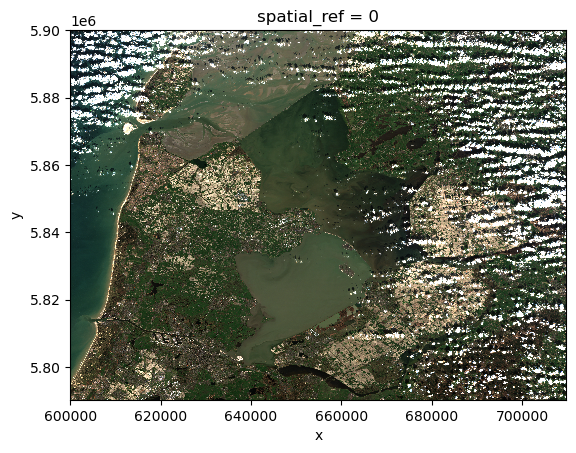

In [22]:
visual.plot.imshow()

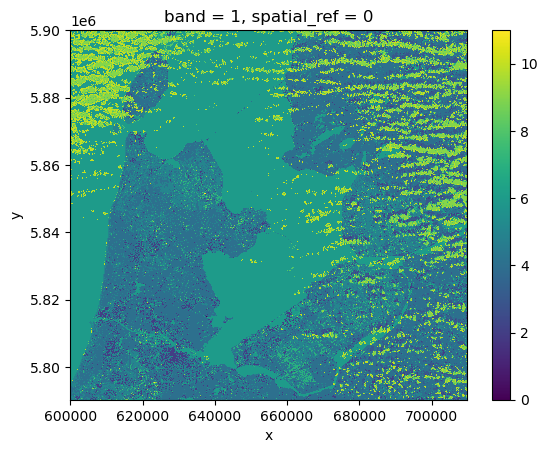

In [24]:
scl.plot()

In [32]:
%%time
mask = scl.isin([8, 9]).squeeze()
visual_masked = visual.where(~mask, other=visual.rio.nodata)
visual_masked.rio.to_raster("band_masked.tif")

CPU times: user 306 ms, sys: 351 ms, total: 657 ms
Wall time: 698 ms


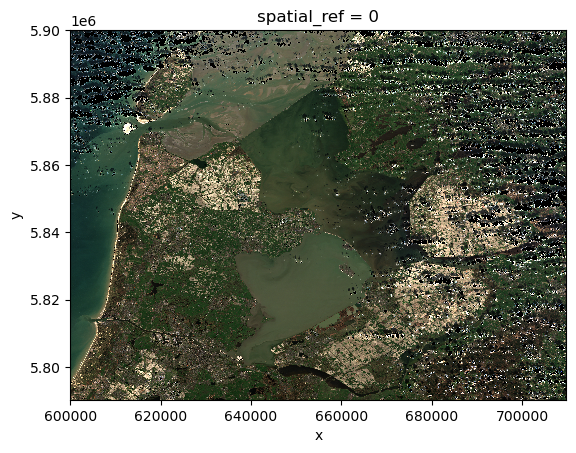

In [33]:
visual_masked.plot.imshow()

In [34]:
scl

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
array([[[ 6,  6,  6, ...,  4,  4,  4],
        [ 6, 10, 10, ...,  4,  4,  4],
        [ 6, 10, 10, ...,  4,  4,  4],
        ...,
        [ 7,  7,  8, ...,  4,  4,  4],
        [ 7,  7,  5, ...,  4,  4,  4],
        [ 5,  5,  7, ...,  4,  4,  4]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  MODE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [37]:
scl = rioxarray.open_rasterio(scl_href, chunks=(1, 2048, 2048), lock=False)
visual = rioxarray.open_rasterio(visual_href, overview_level=0, lock=False, chunks=(3, 2048, 2048))

In [38]:
%%time
scl = scl.persist(scheduler="threads", num_workers=4)
visual = visual.persist(scheduler="threads", num_workers=4)

CPU times: user 2.58 s, sys: 443 ms, total: 3.03 s
Wall time: 8.59 s


In [39]:
from threading import Lock

In [41]:
%%time
mask = scl.isin([8, 9]).squeeze()
visual_masked = visual.where(~mask, other=visual.rio.nodata)
visual_stored = visual_masked.rio.to_raster("band_masked.tif", tiled=True, lock=Lock(), compute=False)

CPU times: user 17.2 ms, sys: 5.36 ms, total: 22.5 ms
Wall time: 22.3 ms


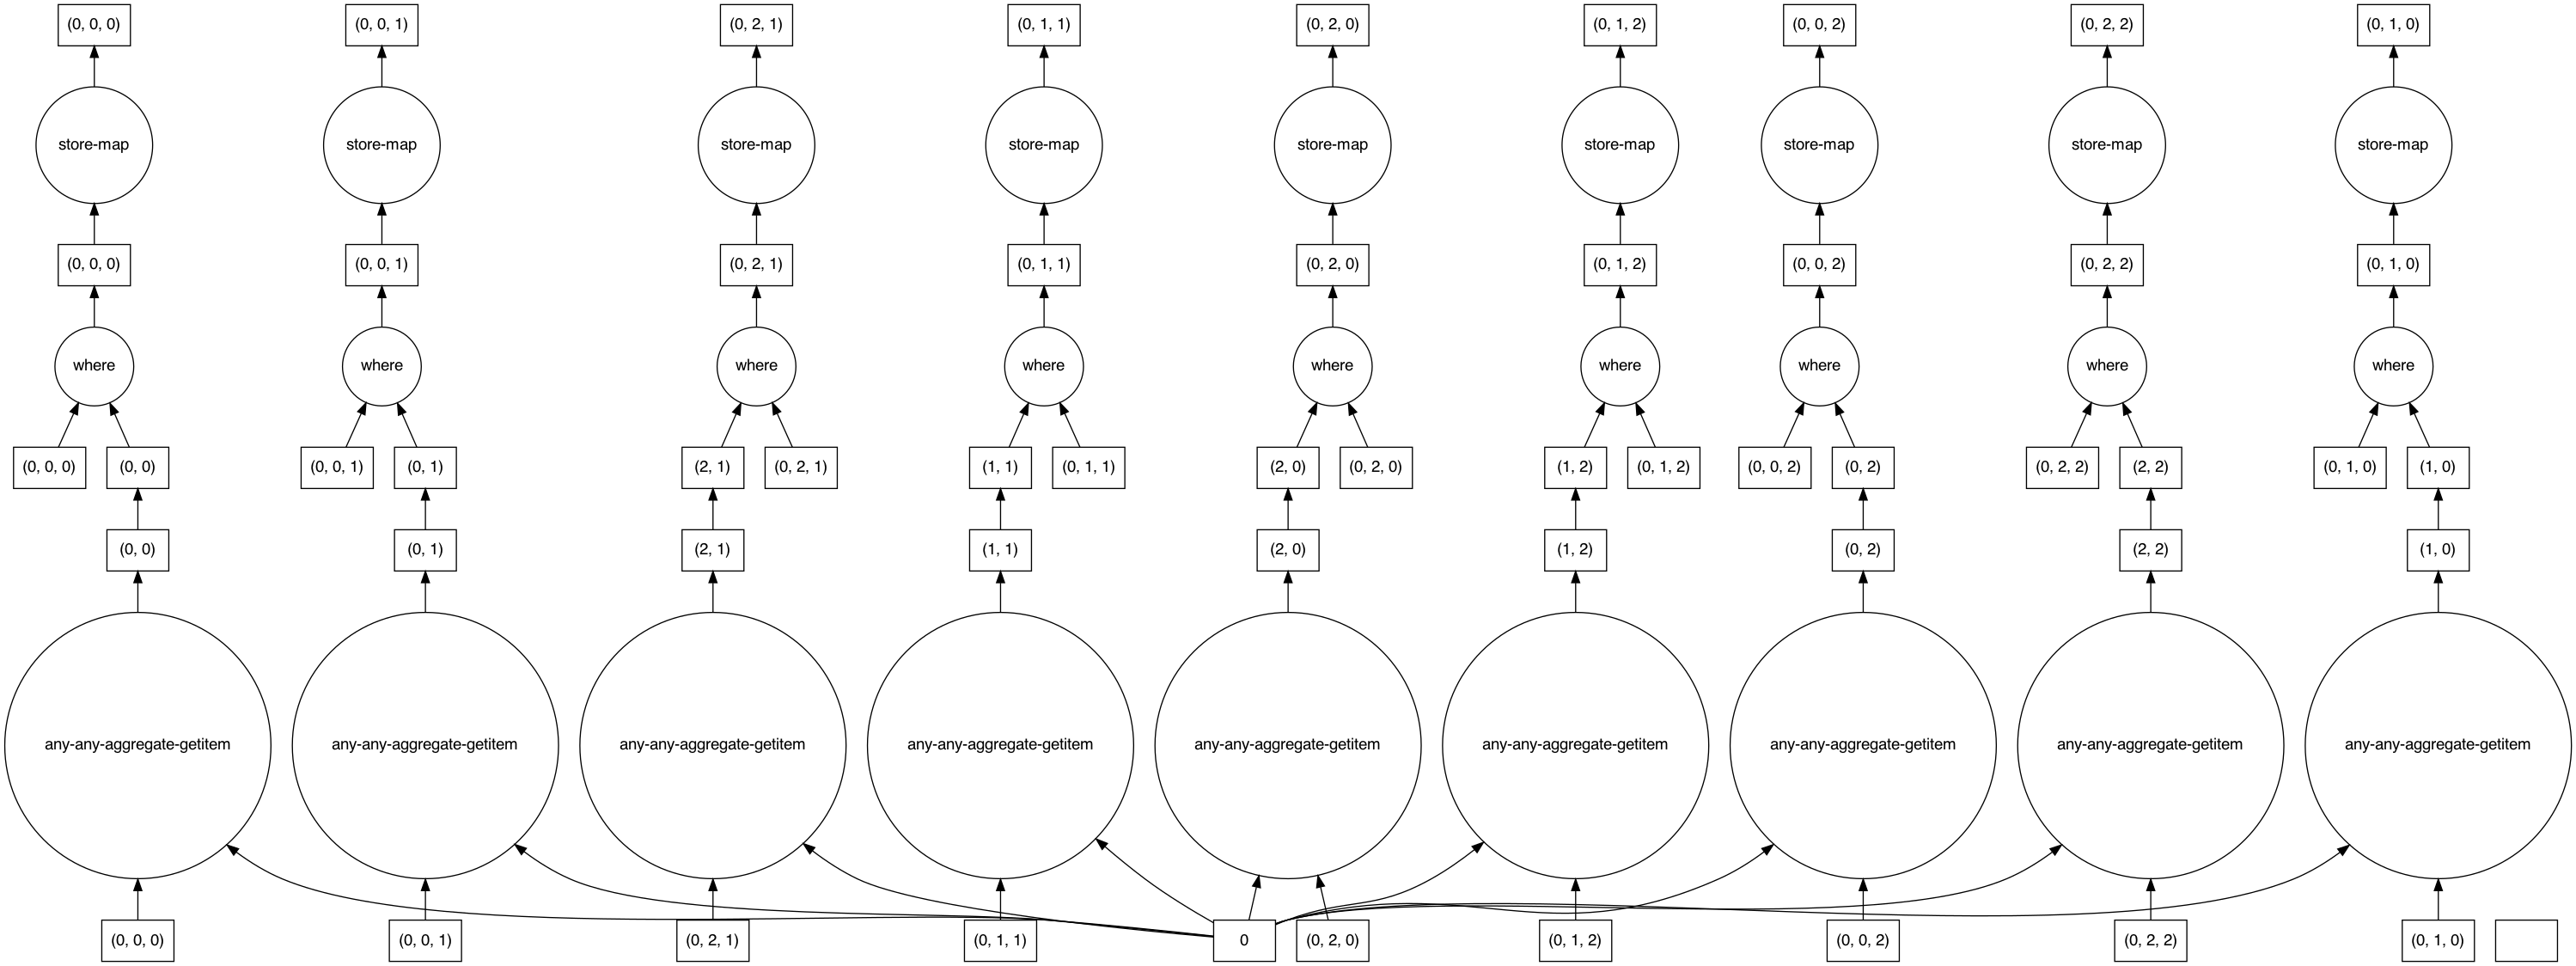

In [42]:
import dask
dask.visualize(visual_stored)

In [43]:
scl

<xarray.DataArray (band: 1, y: 5490, x: 5490)>
dask.array<open_rasterio-5f33ea4c1c36decc7e4fe8da4c85b3d9<this-array>, shape=(1, 5490, 5490), dtype=uint8, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
  * y            (y) float64 5.9e+06 5.9e+06 5.9e+06 ... 5.79e+06 5.79e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  MODE
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [46]:
%%time
visual_stored.compute(scheduler="threads", num_workers=4)

CPU times: user 365 ms, sys: 703 ms, total: 1.07 s
Wall time: 1.11 s


[None, None, None, None, None, None, None, None, None]